# Quasistatic Timoshenko Beam
<div style="text-align: justify"> 
This notebook simulates a cantilever slender beam (one end is clamped at the wall and other is free) bending under the
influence of downward point force applied on the free end. 

Effects of gravity is ignored. In our case, where the shear modulus (G) is comparable to the Young's modulus (E), 
the static deflection of the beam centerline is given by the Timoshenko bending solution.

For more details refer to " Forward and inverse problems in the mechanics of soft filaments " by Gazzola et. al. RSoS. 2018.
</div>

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from elastica._rod import CosseratRod
from elastica.external_forces import EndpointForces
from IPython.display import Image, display

## Initialize Rod

In [2]:
# Number of elements of the rod
nelem = 100

# Direction of the rod
directionRod = np.array([1., 0., 0.])

# Normal of the rod
normalRod = np.array([0., 0., 1.])

# Origin of the rod
originRod = np.array([0., 0., 0.])

# Initial length of the rod [m]
base_length = 3.0

# Initial radius of the rod [m]
base_radius = 0.25

# Density of the rod [kg/m3]
density = 5000.0

# Damping coefficient [kg/(ms)]
nu = 0.1

# Youngs Modulus [Pa]
E = 1e6

# Shear Modulus [Pa]
G = 1e4

# Second moment of inertia
A0 = np.pi * base_radius * base_radius
I0_1 = A0 * A0 / ( 4.0 * np.pi)
I0_2 = I0_1
I0_3 = 2.0 * I0_2
I0 = np.array([I0_1,I0_2,I0_3])

# Mass second moment of inertia for disk cross-section
mass_second_moment_of_inertia = np.zeros((3, 3),np.float64)
np.fill_diagonal(mass_second_moment_of_inertia, I0 * density * base_length/nelem )

# Shear/Stretch matrix
shear_matrix = np.zeros((3, 3),np.float64)
np.fill_diagonal(shear_matrix, [4.0*G*A0/3.0, 4.0*G*A0/3.0, E*A0])

# Bend/Twist matrix
bend_matrix = np.zeros((3, 3),np.float64)
np.fill_diagonal(bend_matrix, [E*I0_1, E*I0_2, G*I0_3])

# Create rod
rod = CosseratRod.straight_rod(nelem, originRod, directionRod, normalRod, base_length, base_radius, density, nu,
                              mass_second_moment_of_inertia, shear_matrix, bend_matrix) 

# Apply end forces
external_force = 15 # External force 
start_force = np.array([0., 0., 0.])
end_force   = np.array([0., -external_force, 0.])
endpt_forces = EndpointForces(rod, start_force, end_force)
endpt_forces.apply_forces()



## Apply Boundary Conditions
<div style="text-align: justify"> 
We applied fixed boundary (applied forces and torques) to the clamped end of the Cosserat rod. 
For the free end we applied free boundary.
</div>

## Timestepper 






## Analytical Solution

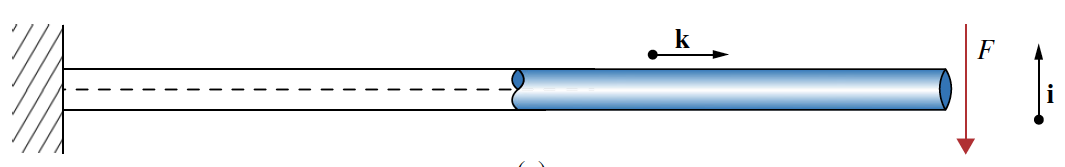

In [11]:
display(Image(filename="assets/timoshenko_beam_figure.png"))

<div style="text-align: justify">  

In order to validate our method and implementation, we compare our simulation solution against the Timoshenko and 
Euler-Bernoulli solutions. 
Timoshenko's model accounts for bending elasticity, rotary inertia and shear deformations, building on classical beam
theories by Rayleigh(bending elasticity and rotary inertia) and Euler-Bernoulli (bending elasticity only). 

We consider a beam clamped at one end $\hat s =0$ and subject to the downward force $F$ at the free end $\hat s = \hat L$.
The static solution for the displacement $y$ along the vertical direction $\bf{i}$. The static solution for the displacement
y along the vertical direction $\bf{i}$ of the rod can then be analytically expressed as

\begin{equation*}
y =  - \frac{F}{{{\alpha _c}\hat AG}}\hat s - \frac{{F\hat L}}{{2E{{\hat I}_1}}}{{\hat s}^2} + \frac{F}{{6E{{\hat I}_1}}}{{\hat s}^3}
\end{equation*}

where $\hat L$ is the length of the rod, $\hat A$ is the constant cross-sectional area, $\hat I_{1}$ is the area second
moment of inertia about the axis $\bf{j}=\bf{k} \times \bf{i}$, $E$ and $G$ are, respectively, the Young's and shear moduli,
and $\alpha _c=4/3$ is the Timoshenko shear factor for circular sections and accounts for the fact that the shear stress 
varies over the section. Furthermore, the Timoshenko theory relies on the assumption of small deflections, so that the 
horizontal coordinate $x$ along the direction $\bf{k}$ can be approximated by the arc-length $\hat s$, hence the use 
of $\hat s$ in the above equation.


If the shear modulus $G$ approaches infinity or if the ratio $E{{\hat I}_1}/\left( {{\alpha _c}{{\hat L}^2}\hat AG} \right) \gg 1$
, then the Timoshenko model in the static case reduces to the Euler-Bernoulli approximation, yielding

\begin{equation*}
y = \hat s - \frac{{F\hat L}}{{2E{{\hat I}_1}}}{{\hat s}^2} + \frac{F}{{6E{{\hat I}_1}}}{{\hat s}^3}
\end{equation*} 

as the shear term of Timoshenko equation becomes negligible.

</div>

In [4]:
# Compute the analytical solutions 
alpha_c = 4.0/3.0
s_postion = np.linspace(0, base_length,nelem+1)

y_timoshenko = -external_force/(alpha_c*A0*G) * s_postion \
               -external_force*base_length/(2.0*E*I0_1) * s_postion * s_postion\
               +external_force/(6*E*I0_1) * s_postion * s_postion * s_postion 

y_euler = -external_force*base_length/(2.0*E*I0_1) * s_postion * s_postion\
          +external_force/(6*E*I0_1) * s_postion * s_postion * s_postion  

## Plotting

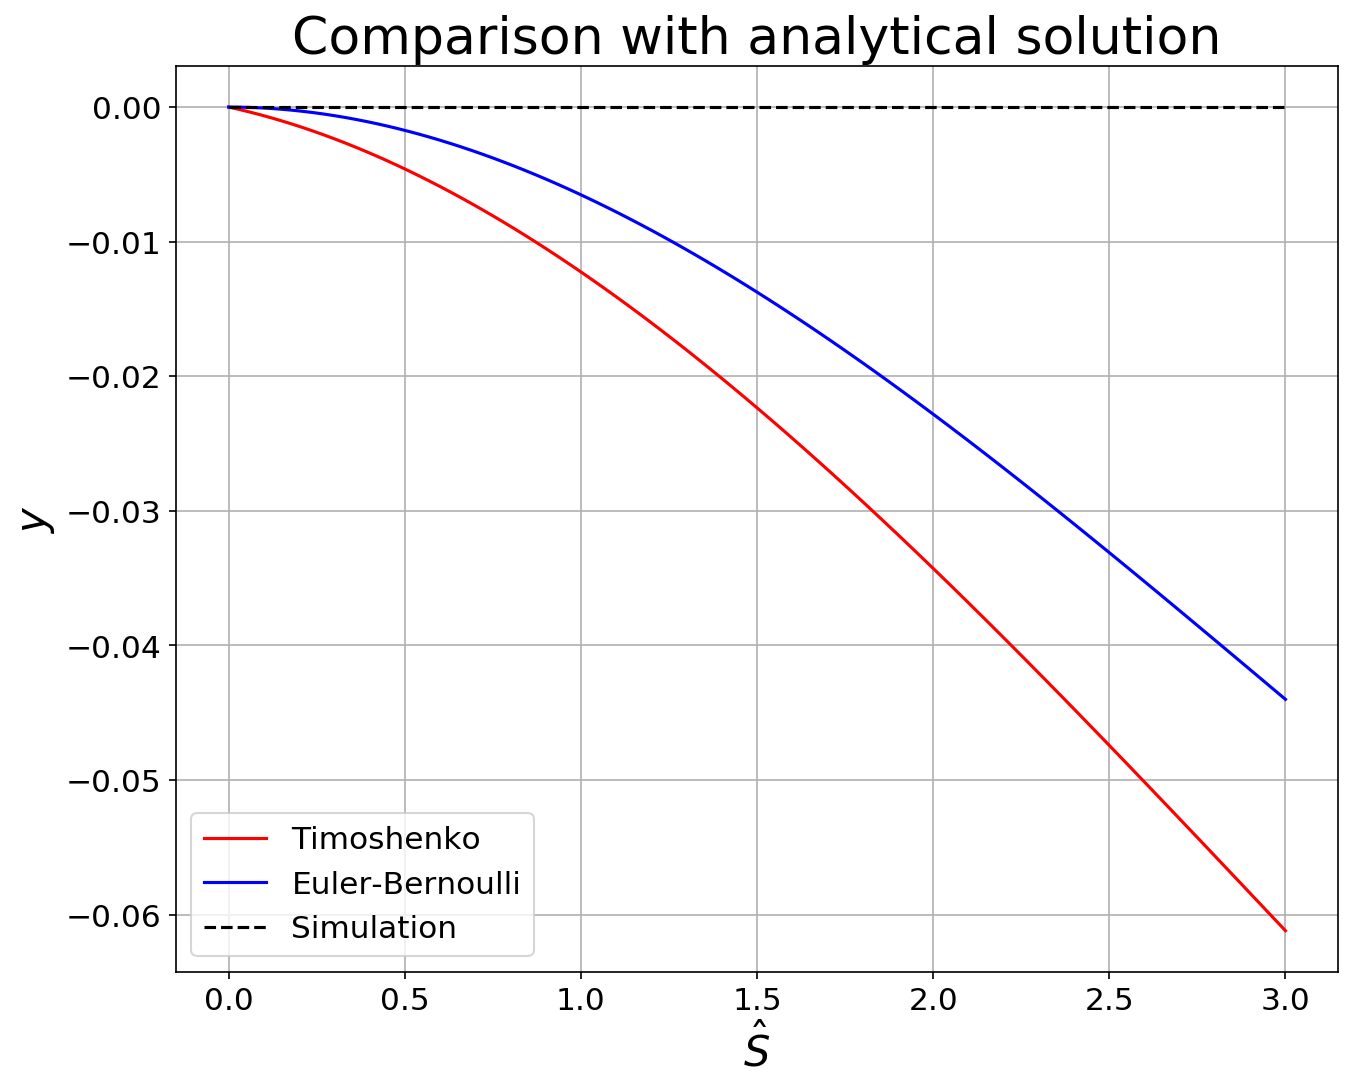

In [5]:
# Plot simulation comparison against the Timoshenko and Euler-Bernoulli
fig = plt.figure(figsize=(10,8),frameon=True,dpi=150)
plt.rcParams.update({'font.size': 15})
plt.plot(s_postion,y_timoshenko, '-r',linewidth=1.5, label='Timoshenko')
plt.plot(s_postion,y_euler, '-b',linewidth=1.5, label='Euler-Bernoulli')
plt.plot(rod.position[0,...],rod.position[1,...], '--k', linewidth=1.5, label='Simulation')
plt.title('Comparison with analytical solution',fontsize=25)
plt.xlabel('$\hat S$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save figure
fig.savefig('timoshenko_test.png', dpi=1200)


